## retrieve data from material project

In [1]:
from mp_api.client import MPRester
key="Z7NcMZxFm5LyvsQZk9k7sD8ZgMdQZstr"

with MPRester(key) as mpr:
    data=mpr.materials.summary.search(formula='ABC3',fields=["structure","material_id","nelements","formula_pretty","formula_anonymous","theoretical","is_stable", "volume", "elements","band_gap","formation_energy"])
    

C:\Users\YujuL\anaconda3\envs\Group\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Retrieving SummaryDoc documents: 100%|██████████| 4555/4555 [00:08<00:00, 545.21it/s]


## Feature Engineering

In [2]:
from matminer.featurizers.bandstructure import BranchPointEnergy
from matminer.featurizers.bandstructure import BandFeaturizer
from matminer.featurizers.structure import XRDPowderPattern
from matminer.featurizers.conversions import StrToComposition

import pandas as pd

In [3]:


stable = []
structures = []
band_gaps = []
theory = []
ids = []
formula=[]
for sample in data:
    stable.append(sample.is_stable)
    structures.append(sample.structure)
    band_gaps.append(sample.band_gap)
    theory.append(sample.theoretical)
    ids.append(sample.material_id)
    formula.append(sample.formula_pretty)

perov_df = pd.DataFrame(
    {"material ids": ids,
     "structure": structures,
     "band gaps": band_gaps,
     "theoretical": theory,
     "stable": stable,
     "formula":formula
    })


In [5]:
real_perovs = perov_df[perov_df["theoretical"]==False]
real_perovs["stable"] = real_perovs["stable"].astype(int)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [6]:
formula_df = StrToComposition().featurize_dataframe(real_perovs, "formula")

StrToComposition: 100%|██████████| 1759/1759 [00:15<00:00, 111.86it/s]


In [7]:
formula_df.head()

,material ids,structure,band gaps,theoretical,stable,formula,composition
14,mp-1105645,"[[7.48401876 2.10527392 7.43781975] Ag, [2.313...",0.2964,False,0,Ag3SBr,"(Ag, S, Br)"
18,mp-22995,"[[ 1.94462322 -1.74755883 1.89344403] Ag, [1....",0.7261,False,0,Ag3SI,"(Ag, S, I)"
19,mp-558189,"[[2.504793 2.504793 0. ] Ag, [2.504793 0....",0.6243,False,0,Ag3SI,"(Ag, S, I)"
27,mp-558950,"[[ 3.68937808 8.09573714 12.24244424] Ag, [0....",0.4985,False,0,AgAsO3,"(Ag, As, O)"
33,mp-23548,"[[2.01581009 0. 0.62870294] Ag, [13.30...",0.0000,False,0,AgBiO3,"(Ag, Bi, O)"


In [8]:
from matminer.featurizers.composition import ElementFraction

In [51]:
ef=ElementFraction()
formula_df['element_fraction']=formula_df['composition'].apply(ef.featurize)

In [119]:
y = formula_df["stable"].values
X = np.array(formula_df['element_fraction'])

In [131]:
import numpy as np
X_=[]
for i in range(len(X)):
    array=np.array(X[i])
    X_.append(array)

In [135]:
X=pd.DataFrame(X_)

In [62]:
formula_df.head()

,material ids,structure,band gaps,theoretical,stable,formula,composition,composition_object,element_fraction
14,mp-1105645,"[[7.48401876 2.10527392 7.43781975] Ag, [2.313...",0.2964,False,0,Ag3SBr,"(Ag, S, Br)","(Ag, S, Br)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
18,mp-22995,"[[ 1.94462322 -1.74755883 1.89344403] Ag, [1....",0.7261,False,0,Ag3SI,"(Ag, S, I)","(Ag, S, I)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
19,mp-558189,"[[2.504793 2.504793 0. ] Ag, [2.504793 0....",0.6243,False,0,Ag3SI,"(Ag, S, I)","(Ag, S, I)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
27,mp-558950,"[[ 3.68937808 8.09573714 12.24244424] Ag, [0....",0.4985,False,0,AgAsO3,"(Ag, As, O)","(Ag, As, O)","[0, 0, 0, 0, 0, 0, 0, 0.6, 0, 0, 0, 0, 0, 0, 0..."
33,mp-23548,"[[2.01581009 0. 0.62870294] Ag, [13.30...",0.0000,False,0,AgBiO3,"(Ag, Bi, O)","(Ag, Bi, O)","[0, 0, 0, 0, 0, 0, 0, 0.6, 0, 0, 0, 0, 0, 0, 0..."


In [137]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [55]:
models=[]
accuracy=[]

## SVM 

In [56]:
from sklearn.svm import SVC

In [57]:
svc = SVC()

param_grid={'kernel':['linear','poly','rbf','sigmoid'],
            'degree':[1,2,3,4],
            'gamma':[0.05,0.1,0.2,0.5,0.7,1.2],
            'C':[0.1,0.2,0.3,0.4,1]
           }


In [58]:
##RandomizedSearchCV to find the best parameter

In [138]:
from sklearn.model_selection import RandomizedSearchCV

rand_ser = RandomizedSearchCV(estimator=svc,param_distributions=param_grid,n_iter=10,)
rand_ser.fit(X_train,y_train)
print(f'best parameter:{rand_ser.best_params_}')
print(f'best score:{rand_ser.best_score_}')

best parameter:{'kernel': 'rbf', 'gamma': 1.2, 'degree': 3, 'C': 1}
best score:0.673042073647813


In [139]:
svc_model=rand_ser.best_estimator_
svc_model.fit(X_train,y_train)

SVC(C=1, gamma=1.2)

In [140]:
from sklearn.metrics import classification_report

In [141]:
y_pred = svc_model.predict(X_test)
testing_accuracy = svc_model.score(X_test, y_test) * 100
models.append('SVC')
accuracy.append(testing_accuracy)
print(f'Accuracy on test data: {testing_accuracy:.1f} %')
print(classification_report(y_test,y_pred,zero_division=1))

Accuracy on test data: 65.9 %
              precision    recall  f1-score   support

           0       0.65      0.88      0.74       199
           1       0.70      0.37      0.49       153

    accuracy                           0.66       352
   macro avg       0.67      0.63      0.62       352
weighted avg       0.67      0.66      0.63       352



In [142]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

### Random Forest

In [144]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()

grid_param={'n_estimators':range(1,1000)}

rand_ser = RandomizedSearchCV(estimator=rf,param_distributions=grid_param,n_iter=10,)
rand_ser.fit(X_train,y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'n_estimators': range(1, 1000)})

In [145]:
print(f'best parameter:{rand_ser.best_params_}')
print(f'best score:{rand_ser.best_score_}')

best parameter:{'n_estimators': 334}
best score:0.6432195048080565


In [146]:
rf_model=rand_ser.best_estimator_

In [147]:

y_pred=rf_model.predict(X_test)
testing_accuracy = rf_model.score(X_test, y_test) * 100
models.append('Randomforest')
accuracy.append(testing_accuracy)
print(f' Accuracy on test data: {testing_accuracy:.1f} %')
print(classification_report(y_test,y_pred))

 Accuracy on test data: 67.3 %
              precision    recall  f1-score   support

           0       0.68      0.79      0.73       199
           1       0.66      0.52      0.58       153

    accuracy                           0.67       352
   macro avg       0.67      0.66      0.66       352
weighted avg       0.67      0.67      0.67       352



## LogisticRegression

In [150]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lr=LogisticRegression(max_iter=1000)
grid_param={'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}

grid_ser = GridSearchCV(estimator=lr,param_grid=grid_param,cv=5,scoring='accuracy')
grid_ser.fit(X_train,y_train)

print(f'best parameter:{grid_ser.best_params_}')
print(f'best score:{grid_ser.best_score_}')

best parameter:{'C': 1, 'solver': 'lbfgs'}
best score:0.6694959743570328


In [151]:
lr_model=grid_ser.best_estimator_
lr_model.fit(X_train, y_train)
y_pred=lr_model.predict(X_test)
testing_accuracy = lr_model.score(X_test, y_test) * 100
models.append('LogisticRegression')
accuracy.append(testing_accuracy)
print(f' Accuracy on test data: {testing_accuracy:.1f} %')
print(classification_report(y_test,y_pred))

 Accuracy on test data: 69.0 %
              precision    recall  f1-score   support

           0       0.67      0.88      0.76       199
           1       0.74      0.44      0.56       153

    accuracy                           0.69       352
   macro avg       0.71      0.66      0.66       352
weighted avg       0.70      0.69      0.67       352



## XGBoost

In [152]:
import xgboost as xgb

In [153]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train,y_train)
y_pred=xgb_model.predict(X_test)
testing_accuracy = xgb_model.score(X_test, y_test) * 100
models.append('XGBoost')
accuracy.append(testing_accuracy)
print(f' Accuracy on test data: {testing_accuracy:.1f} %')
print(classification_report(y_test,y_pred))

 Accuracy on test data: 67.9 %
              precision    recall  f1-score   support

           0       0.69      0.77      0.73       199
           1       0.65      0.56      0.60       153

    accuracy                           0.68       352
   macro avg       0.67      0.66      0.67       352
weighted avg       0.68      0.68      0.67       352



## Decision Trees

In [154]:
from sklearn.tree import DecisionTreeClassifier

In [155]:
dt_model=DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train,y_train)
y_pred=dt_model.predict(X_test)
testing_accuracy = dt_model.score(X_test, y_test) * 100
models.append('DecisionTree')
accuracy.append(testing_accuracy)
print(f' Accuracy on test data: {testing_accuracy:.1f} %')
print(classification_report(y_test,y_pred))

 Accuracy on test data: 65.9 %
              precision    recall  f1-score   support

           0       0.68      0.75      0.71       199
           1       0.63      0.54      0.58       153

    accuracy                           0.66       352
   macro avg       0.65      0.64      0.65       352
weighted avg       0.66      0.66      0.65       352



## KNN

In [156]:
from sklearn.neighbors import KNeighborsClassifier

In [157]:
knn_model = KNeighborsClassifier(n_neighbors=4)
knn_model.fit(X_train,y_train)
y_pred=knn_model.predict(X_test)
testing_accuracy = knn_model.score(X_test, y_test) * 100
models.append('KNN')
accuracy.append(testing_accuracy)
print(f' Accuracy on test data: {testing_accuracy:.1f} %')
print(classification_report(y_test,y_pred))

 Accuracy on test data: 63.9 %
              precision    recall  f1-score   support

           0       0.64      0.81      0.72       199
           1       0.63      0.42      0.50       153

    accuracy                           0.64       352
   macro avg       0.64      0.61      0.61       352
weighted avg       0.64      0.64      0.62       352



In [158]:
import matplotlib.pyplot as plt

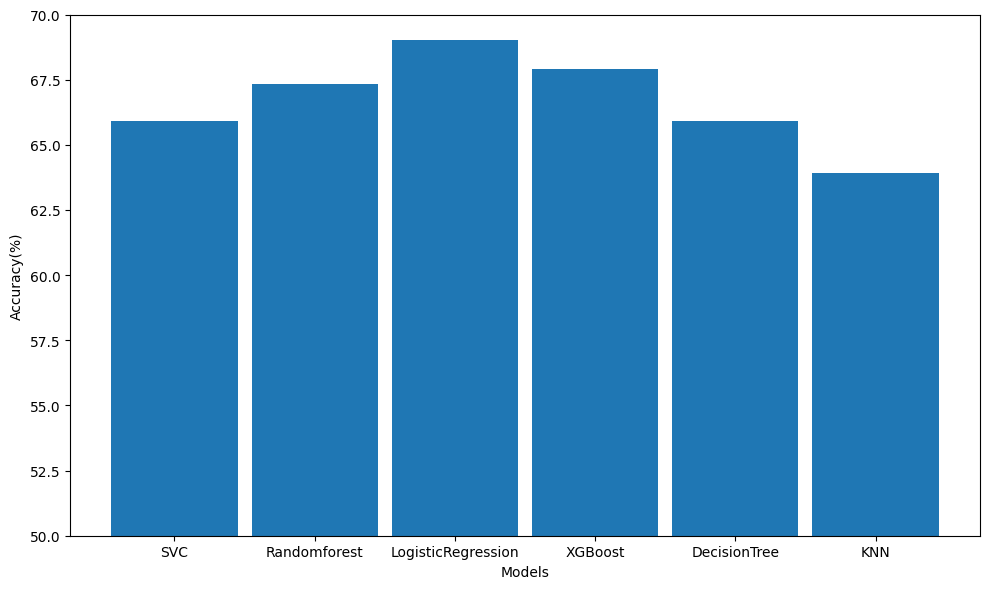

In [160]:
plt.figure(figsize=(10, 6))
plt.bar(models,accuracy,width=0.9)
plt.xlabel('Models')
plt.ylabel('Accuracy(%)')
plt.ylim(50, 70)
plt.tight_layout()
plt.show()